# Sentiment Analysis - Identification of Tweets Containing Offensive Language and Hate Speech
**Authors:** Chloe Maine, Drena Mitfari and Kristin Lomicka \
**Date:** February 28, 2020


## Overview and Scope:
- **Objective:** Our initial objective was to build an RNN capable of performing a binary classification of tweets containing offensive language vs. those that do not contain offensive language and experiment with the objective function, number of layers and layer size in order to improve model performance. As an extension, we also created an RNN capable of performing a multi-class model capable of predicting three classes - hate speech, offensive language and neither.
    - Note that this notebook contains the methodology and results for the binary and multiclass models and the code for the binary models. The code for the multi-class models is presented in the 'extension_chloe_drena_kristin.ipynb' notebook.
- **Data:** Davidson et al.: https://github.com/t-davidson/hate-speech-and-offensive-language
    - The dataset contains over 24K tweets that were coded as either 'hate speech' (class 0), 'offensive language' (class 1), or 'neither' (class 2) by CrowdFlower users. Each tweet was classified by at least three users and the final class label reflects that of the majority of users. 
    - The histogram below displays the class distribution of the data set. There is a strong class imbalance, which we attempted to address by adding weights to the multi-class model. 
    - For the binary classification model, we combined 'hate speech' and 'offensive language' into a single class to predict 'offensive language' vs. 'other'. This decision was driven in part by the class imbalance. If we had more balanced classes, we would have been more interested in predicting 'hate speech' and 'offensive language' vs. 'neither'.
<img src="histogram.png" width="500">

- **Data Pre-processing:** The tweets were pre-processed by doing the following:
    - Lemmatised and stemmed words; this allows us to reduce the dimension of the input by taking just the word stem from different words with the same meaning (see here for further details: https://tartarus.org/martin/PorterStemmer/ ) 
    - Removed stop words (Stop words are small words such as in, a, as, to that do not help us in interpreting the sentiment of a tweet.) These step additionally helps in dimensionality reduction.
    - Removed manually identified words which do not assist in helping us to classify tweets
    - Removed uncommon words as these words are too infrequent to be reliable predictors of sentiment.
    - Created unique word list - a necessary step in order to convert words to an index by creating a dictionary of unique words.

- **Data Preparation:** 
    - **Input features:** Our models require each tweet to be in the form of a vector that contains the index number of the word in the dictionary. In order to create the input, we:
        - Created a dictionary of unique words
         - One-hot encoded the words in each tweet - The one-hot encoding turned each word into a vector of 0s and 1s. By one-hot encoding the tweets before converting them to a vector of indices, we afforded ourselves flexibility for the model input as some model types (e.g., Convolutional Networks require a one-hot encoded vector). 
        - Encoded each tweet with the index number of the word in the dictionary - Each one-hot encoded word was replaced with its index from the dictionary.
        - Padded the data to ensure each tweet is the same length.
    - **Train-Test Split:** We performed an 80/20 train-test split.
        - For the multi-class model, the split accounts for class imbalance between hate speech/offensive language/neutral by proportionally sampling across all 3 classes
    - **Target Variable:** A vector containing the true class of each tweet. 

- **Models:** 
    - **Binary Class Models:** We compared the six models below. The key factors changed are the objective function, number of layers and size of layers. All models are optimized using the binary cross entropy loss function, over 600 epochs, with a learning rate of 0.1. 
         - **Model 1:** Single layer RNN with tanh activation function
         - **Model 2:** Single layer RNN with reLU activation function
         - **Model 3:** Two layer (same size) RNN with tanh activation function
         - **Model 4:** Two layer (same size) RNN with reLU activation function
         - **Model 5:** Two layer (different-sized) RNN with relu activation function
         - **Model 6:** Three layer (different sized) RNN with relu activation function
    - **Multi-Class Models:** We compared the four multi-class models below. The key factors changed were the number of layers in the RNN and the class weights in the loss function. As mentioned above, we added class weights to the loss function of the multi-class model in order to address the class imbalance in the training data. All models used the reLU activation function in the RNN layer, the cross entropy loss, 600 epochs and a learning rate of 0.1.
         - **Model 1:** Single layer RNN with reLU activation, no class weights
         - **Model 2:** Single layer RNN with reLU activation, with class weights
         - **Model 3:** Three layer RNN with reLU activation, no class weights
         - **Model 4:** Three layer RNN with reLU activation, with class weights
        
     

## Results - Binary Classification Model
**Training Results:** Based on the training data, Model 6 (Three Layer (diff size) reLU) had the smallest loss. It also converged the fastest and had the least noise after ~350 epochs compared to the other models. Model 2 (Two Layer (same size) Tanh) had the highest loss. In addition, the models with the reLU activation function in the RNN layer (Models 2 and 4) performed better than those with the tanh (Models 1 and 3). 

<img src="train_loss.png" width="500">

**Test Results:** Interestingly, when we test the models, Model 4 (Two layer (same size) reLU) out performs the others with the smallest loss and highest accuracy and Model 6 (Three Layer (diff size) reLU), the strongest in the training set, had the highest loss and lowest accuracy. 

<img src="pred_loss.png" width="500">

The confusion matrices depicting the prediction accuracy are pictured below. 
<img src="confusion.png" width="1000">

## Results - Multi-Class Classification Model
**Training Results:**  Model 3 (three layers, no weights) yielded the smallest loss at 0.9071, followed by Model 1 (single layer, no weights) with 0.9097, on the training data, which Model 4 (three layers, weights) yielded the highest loss at 0.9306.

<img src="train_loss_multi.png" width="500">

**Test Results:** In the case of the multi-class model, the test results are consistent with the training results. Model 3 performed the best with the smallest error and highest accuracy, followed by Model 1. Model 4 performed the worst with the highest error. Interestingly, though, if we look at the confusion matrices, Model 3 classified almost every tweet as class 1 ("offensive language"). Given the high concentration of that class in our sample data, it could explain the high accuracy. Interestingly, Model 4 (three layers, weights) had lower accuracy but predicted classes were more distributed across each label. 

<img src="test_loss_multi.png" width="500">

The confusion matrices depicting the prediction accuracy are pictured below. 
<img src="confusion_multi.png" width="1000">

## Results - Predicting an individual tweet
We also created a function that allows you to type in a sample 'tweet' and use the binary classification model to determine if it is offensive or not. We tested the function with tweets from Donald Trump that came up under a google search for 'Donald Trump Top Offensive Tweets'. As you can see below, all the tweets were categorized as offensive. 

<img src="trump_tweets.png" width="1000">

## Code

In [7]:
# Import required packages

import torch
from torch import nn
import pandas as pd

import numpy as np
from numpy import asarray
from numpy import save

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from operator import itemgetter
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, confusion_matrix

### Functions to Clean Data:

In [12]:
# Define list of manually identified words to remove
words_to_remove = ['said', 'wa', 'year', 'ha', 'would', 'new', 'also', 'say', '_', 'could', \
                   'go', 'make', 'told', 'like', 'get', 'made', 'even', 'still', 'mr', 'much',\
                   'u', 'inc', 'must', 'ie', 'thing', 'sen', 'th', 'other', 'went', 'de', 'non', \
                   'st', 'done', 'let', 'n', 'jr', 'ever', 'yet', 'ta',\
                  'lt', 'j', 'al', 'us', 'pre', 'el', 'b', 'onto', 'l', 'w', 'v', '&']

# Clean document and remove special characters
def lemmatize(X):
    documents = []
    stemmer = WordNetLemmatizer()
    for sen in range(0, len(X)):
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(X[sen]))
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document)
        # Removing digits
        document = re.sub("\d+", "", document)
        # Converting to Lowercase
        document = document.lower()
        # Lemmatization
        document = document.split()
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        documents.append(document)
    return documents

# Separate the words in each document into lists. Tokens is a list of lists.
def create_doc_list(documents):
    tokens = []
    list_of_lists = [[doc] for doc in documents]
    for list in list_of_lists:
        for word in list:
            tokens.append(word_tokenize(word))
    return tokens

# Filter out the stopwords
def filter_stopwords(documents):
    stop_words = set(stopwords.words('english'))
    document_list = []
    for doc in documents:
        filtered_words = []
        for word in doc:
            if word not in stop_words:
                filtered_words.append(word)
        document_list.append(filtered_words)
    return document_list

# Stem the words
def stemmer(documents):
    porter = PorterStemmer()
    document_list = []
    for doc in documents:
        stemmed_words = []
        for word in doc:
            stemmed_words.append(porter.stem(word))
        document_list.append(stemmed_words)
    return document_list


# Identify the words that occur less than 20 times in all documents
def uncommon_words(stemmed_documents, word_threshold = 20):
    word_count = pd.DataFrame(pd.DataFrame([word for doc in stemmed_documents for word in doc])[0].value_counts())
    word_count_slim = word_count.drop(word_count.loc[word_count[0]<=word_threshold].index, inplace=False)
    # Put the uncommon words into a list
    uncommon_words = word_count.loc[word_count[0]<=word_threshold]
    uncommon_word_list = uncommon_words.index.tolist()
    return uncommon_word_list

# Remove uncommon words
def rm_uncommon(documents, words_to_remove):
    uncommon_words = set(words_to_remove)
    document_list = []
    new_unique_words = []
    for doc in documents:
        filtered_words = []
        for word in doc:
            if word not in uncommon_words:
                filtered_words.append(word)
        document_list.append(filtered_words)
    return document_list

# Create list of unique words across all documents
def uniqueWords(documents):
    combined_docs = set([word for doc in documents for word in doc])
    unique_word_list = list((combined_docs))
    return unique_word_list

# Remove words from documents and generate a new list of unique words

def filterWords_generateWordList(documents, unique_words, words_to_remove):
    uncommon_words = set(words_to_remove)
    document_list = []
    new_unique_words = []
    for doc in documents:
        filtered_words = []
        for word in doc:
            if word not in uncommon_words:
                filtered_words.append(word)
        document_list.append(filtered_words)
    for word in unique_words:
        if word not in uncommon_words:
            new_unique_words.append(word)
    return document_list, new_unique_words

def onehot_encoder(documents, word_list):
    n=len(word_list)
    doc_list=[]
    dictionary = {word:idx for idx,word in enumerate(word_list)}
    for doc in documents:
        word_list=[]
        for word in doc:
            index=dictionary[word]
            word_onehot=np.zeros(n)
            word_onehot[index]=1
            word_list.append(word_onehot)
        doc_list.append(word_list)
    return doc_list

def encoder_index(documents):
    encoded_docs = []
    for document in documents:
        encoded_words = []
        for word in document:
            position = [i for i, e in enumerate(word) if e != 0]
            encoded_words += position
        encoded_docs.append(encoded_words)
    return encoded_docs

### Load Prepared Data and Create Variables:

In [3]:
# load data
labeled_data = pd.read_csv("data/labeled_data.csv") # original data with classification
doclist_idx = np.load("data/doclist_idx_lg_padded.npy", allow_pickle = True) # doc list with words represented by index #
word_list = np.load("data/unique_words_lg.npy", allow_pickle = True) # list of unique words
uncommon_words = np.load("data/uncommon_word_list.npy", allow_pickle = True) # list of uncommon words

In [4]:
# Convert data to a binary data set by combining class 1 and 2
labeled_data.loc[labeled_data['class'] != 1, "new_class"] = 0
labeled_data.loc[labeled_data['class'] == 1, "new_class"] = 1
labeled_data["new_class"]=labeled_data["new_class"].apply(np.int64)

# Create target variable
target_seq = labeled_data["new_class"]

labeled_data.head() # 0 = hate/neither, 1 = offensive

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,new_class
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


Text(0.5, 1.0, 'Binary-Class Value Counts')

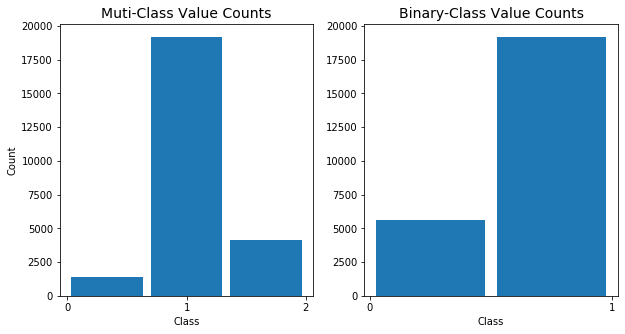

In [5]:
# Plot the class distribution for the binary and multi-class data sets
f = plt.figure(figsize = (10,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

p1 = ax1.hist(labeled_data["class"], bins = 3, rwidth = .9, label = ("1", "2", "3"))
p2 = ax2.hist(labeled_data["new_class"], bins = 2, rwidth = .9)
ax1.set_ylabel('Count', fontsize = 10)
ax1.set_xlabel('Class', fontsize = 10)
ax2.set_xlabel('Class', fontsize = 10)
ax1.set_xticks([0, 1, 2])
ax2.set_xticks([0, 1])
ax1.set_title('Muti-Class Value Counts', fontsize = 14)
ax2.set_title('Binary-Class Value Counts', fontsize = 14)

In [6]:
doclist_idx = list(doclist_idx)

In [7]:
# Convert input and target sequences to tensors
input_seq = torch.from_numpy(np.asarray(doclist_idx))
target_seq = torch.Tensor(np.asarray(target_seq))
word_dict = { i : word_list[i] for i in range(0, len(word_list) ) }

In [8]:
# train test split

train_ratio = 0.8
total = len(input_seq)
train_cutoff = int(total * train_ratio)

train_x, train_y = input_seq[:train_cutoff], target_seq[:train_cutoff]
test_x, test_y = input_seq[train_cutoff:], target_seq[train_cutoff:]

### Models:

In [10]:
# Feature to determine whether the code is running on a GPU or CPU

# Returns a Boolean True if a GPU is available, otherwise returns False
is_cuda = torch.cuda.is_available()

# Set the device to GPU if one is available. Otherwise device will be set to CPU
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


#### Model for Binary Classification

In [8]:
# Model for the Recurrant Neural Network
## It has the ability to run up to three different RNN layers depending on model parameters

class Model(nn.Module):
    def __init__(self, nonlinearity, dict_size, embedding_size, output_size, hidden_dim1, hidden_dim2, hidden_dim3, 
                 n_stacked_layers, n_diff_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.n_stacked_layers = n_stacked_layers
        self.n_diff_layers = n_diff_layers
        self.embedding_size = embedding_size
        self.nonlinearity = nonlinearity

        #defining embedding
            # The number of embeddings should be the dictionary size
        self.embedding = nn.Embedding(num_embeddings=dict_size, embedding_dim=embedding_size)

        #Defining the layers
        #Defining the layers
        ## RNN Layer
        self.rnn1 = nn.RNN(embedding_size, hidden_dim1, n_stacked_layers, nonlinearity=nonlinearity, batch_first=True)   
        self.rnn2 = nn.RNN(hidden_dim1, hidden_dim2, n_stacked_layers, nonlinearity=nonlinearity, batch_first=True)
        self.rnn3 = nn.RNN(hidden_dim2, hidden_dim3, n_stacked_layers, nonlinearity=nonlinearity, batch_first=True) 
        
        ## Fully connected layer
        self.fc1 = nn.Linear(hidden_dim1, output_size)
        self.fc2 = nn.Linear(hidden_dim2, output_size)
        self.fc3 = nn.Linear(hidden_dim3, output_size)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        #compute embedding
        x = self.embedding(x)  #x is bs,max_seq_len,embedding size
        
        # Passing in the input and hidden state into the model and obtaining outputs
        if self.n_diff_layers == 1:
            out, hidden = self.rnn1(x, last_state)
            out = self.fc1(out)
        if self.n_diff_layers == 2:
            x, hidden = self.rnn1(x, last_state)
            out, hidden = self.rnn2(x, last_state)
            out = self.fc2(out)
        if self.n_diff_layers == 3:
            x, hidden = self.rnn1(x, last_state)
            x, hidden = self.rnn2(x, last_state)
            out, hidden = self.rnn3(x, last_state)
            out = self.fc3(out)
           
        # take mean to get single probability for each tweet
        out = torch.mean(out, dim=1)
        
        out = self.sigmoid(out)
        
        return out, hidden

### Train the Models

In [ ]:
# Define global hyper parameters
dict_size = len(word_dict)
n_epochs = 600
lr=0.01

#### Model 1: Single layer (same size) Tanh

In [ ]:
# Instantiate the model - set nonlinearity = "tanh", n_stacked_layers = 1
model = Model(nonlinearity = "tanh", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=1, n_diff_layers=1)

#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

# n_epochs = 300
# lr=0.1

# Define loss and optimizer
#criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model_1 = model
loss_1 = loss
loss1_values_1 = loss_values

#### Model 2: Single layer (same size) reLU

In [ ]:
# Instantiate the model - set nonlinearity = "relu", n_stacked_layers = 1 and n_diff_layers = 1
model = Model(nonlinearity = "relu", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=1, n_diff_layers=1)

#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

model_2 = model
loss_2 = loss
loss_values_2 = loss_values

#### Model 3: Two layers (same size) Tanh

In [ ]:
# Instantiate the model - set nonlinearity = "tanh", n_stacked_layers = 2 and n_diff_layers = 1
model = Model(nonlinearity = "tanh", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=2, n_diff_layers=1)

#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

model_3 = model
loss_3 = loss
loss_values_3 = loss_values

#### Model 4: Two layers (same size) reLU

In [ ]:
# Instantiate the model - set nonlinearity = "relu", n_stacked_layers = 2 and n_diff_layers = 1
model = Model(nonlinearity = "relu", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=2, n_diff_layers=1)

#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

model_4 = model
loss_4 = loss
loss_values_4 = loss_values

#### Model 5: Two layers (different sizes) reLU

In [ ]:
# Instantiate the model - set nonlinearity = "relu", n_stacked_layers = 1 and num_diff_layers = 2
model = Model(nonlinearity = "relu", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=1, n_diff_layers=2)


#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training Run
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

model_5 = model
loss_5 = loss
loss_values_5 = loss_values

#### Model 6: Three layers (different sizes) reLU

In [ ]:
# Instantiate the model - set nonlinearity = "relu", n_stacked_layers = 1, and num_diff_layers = 3
model = Model(nonlinearity = "relu", dict_size=dict_size, embedding_size=100, output_size=1, 
               hidden_dim1=100, hidden_dim2=50, hidden_dim3=25, n_stacked_layers=1, n_diff_layers=2)

#  Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the model
train_x = train_x.to(device)
train_y = train_y.to(device)

loss_values = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #train_x = train_x.to(device)
    output, hidden = model(train_x)
    output = output.to(device)

    loss = criterion(output.view(-1), train_y.view(-1))
    loss_values.append(loss)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

model_6 = model
loss_6 = loss
loss_values_6 = loss_values

In [ ]:
# import pickle
# # pickling the models

# mod_1 = open('model_1', 'wb')
# pickle.dump([model_1, loss_1, loss1_values_1], mod_1)

# mod_2 = open('model_2', 'wb')
# pickle.dump([model_2, loss_2, loss_values_2], mod_2)

# mod_3 = open('model_3', 'wb')
# pickle.dump([model_3, loss_3, loss_values_3], mod_3)

# mod_4 = open('model_4', 'wb')
# pickle.dump([model_4, loss_4, loss_values_4], mod_4)

# mod_5 = open('model_5', 'wb')
# pickle.dump([model_5, loss_5, loss_values_5], mod_5)

# mod_6 = open('model_6', 'wb')
# pickle.dump([model_6, loss_6, loss_values_6], mod_6)

In [9]:
# load pickle files
import pickle

# with open('model_1', 'rb') as mod_1:
#     model_1, loss_1, loss1_values_1 = pickle.load(mod_1)
    
# with open('model_2', 'rb') as f:
#     model_2, loss_2, loss_values_2 = pickle.load(f)
    
# with open('model_3', 'rb') as f:
#     model_3, loss_3, loss_values_3 = pickle.load(f)
    
# with open('model_4', 'rb') as f:
#     model_4, loss_4, loss_values_4 = pickle.load(f)
    
# with open('model_5', 'rb') as f:
#     model_5, loss_5, loss_values_5 = pickle.load(f)
    
with open('model_6', 'rb') as f:
    model_6, loss_6, loss_values_6 = pickle.load(f)


#### Training Results

In [ ]:
# Plot training results for the models

f = plt.figure(figsize = (30,10))
ax1 = f.add_subplot(121)

p1 = ax1.plot(loss1_values_1)
p2 = ax1.plot(loss_values_2)
p3 = ax1.plot(loss_values_3)
p4 = ax1.plot(loss_values_4)
p5 = ax1.plot(loss_values_5)
p6 = ax1.plot(loss_values_6)
ax1.set_ylabel('Loss', fontsize = 10)
ax1.set_xlabel('epochs', fontsize = 10)
ax1.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('tanh-1L', 'reLU-1L', 'tanh-2L (same size)', 
                                                        'reLU-2L (same size)', 'reLU-2L (diff size)', 
                                                        'reLU-3L (diff size)'))
ax1.set_title('Binary Classification: Loss per Epoch', fontsize = 14)

print("Tanh 1L loss:" + str(loss_1))
print("reLU 1L loss: "+ str(loss_2))
print("Tanh 2L (same size) loss: "+ str(loss_3))
print("reLU 2L (same size) loss: "+ str(loss_4))
print("reLU 2L (diff size) loss: "+ str(loss_5))
print("reLU 3L (diff size) loss: "+ str(loss_6))

### Test the Models

#### Test Functions

In [1]:
# predict with already cleaned data (test_x)

def predict_test_data(model, test_data):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    test_data = test_data.to(device)
    
    if(len(test_data) == 0):
        "Your review must contain at least 1 word!"
        return None
    
    output, _ = model(test_data)
    pred = torch.round(output.squeeze())
    
    results = []
    for i in pred:
        if i == 0:
            results.append('This is hate speech or neutral.') 
        else:
            results.append('This is offensive language.')
    
    return pred

#### Preding Test Data

In [17]:
# prediction results
model_1_pred = predict_test_data(model_1, test_x)
model_1_error = (np.sum(abs(test_y.detach().numpy() - model_1_pred.detach().numpy())))/len(test_y)

model_2_pred = predict_test_data(model_2, test_x)
model_2_error = (np.sum(abs(test_y.detach().numpy() - model_2_pred.detach().numpy())))/len(test_y)

model_3_pred = predict_test_data(model_3, test_x)
model_3_error = (np.sum(abs(test_y.detach().numpy() - model_3_pred.detach().numpy())))/len(test_y)

model_4_pred = predict_test_data(model_4, test_x)
model_4_error = (np.sum(abs(test_y.detach().numpy() - model_4_pred.detach().numpy())))/len(test_y)

model_5_pred = predict_test_data(model_5, test_x)
model_5_error = (np.sum(abs(test_y.detach().numpy() - model_5_pred.detach().numpy())))/len(test_y)

model_6_pred = predict_test_data(model_6, test_x)
model_6_error = (np.sum(abs(test_y.detach().numpy() - model_6_pred.detach().numpy())))/len(test_y)

# Put results in a dataframe
errors = {'Models': ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], 
          'Error': np.array([model_1_error, model_2_error, model_3_error, model_4_error, model_5_error, model_6_error])}
results_df = pd.DataFrame(data=errors)

### Results

#### Test Error Rates

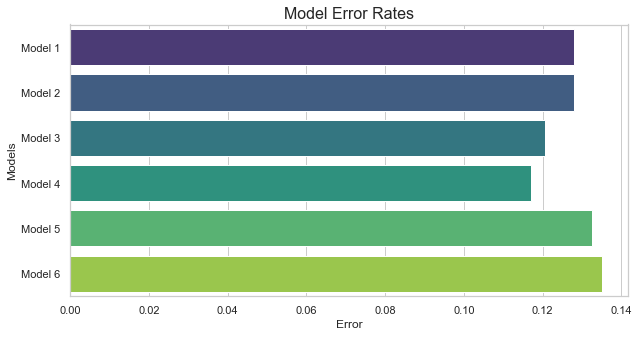

In [18]:
plt.figure(figsize=(10, 5))

sns.set(style='whitegrid')
ax = sns.barplot(x='Error', y='Models', data=results_df, palette='viridis').set_title('Model Error Rates', size=16)

#### Confusion Matrices

Confusion Matrices


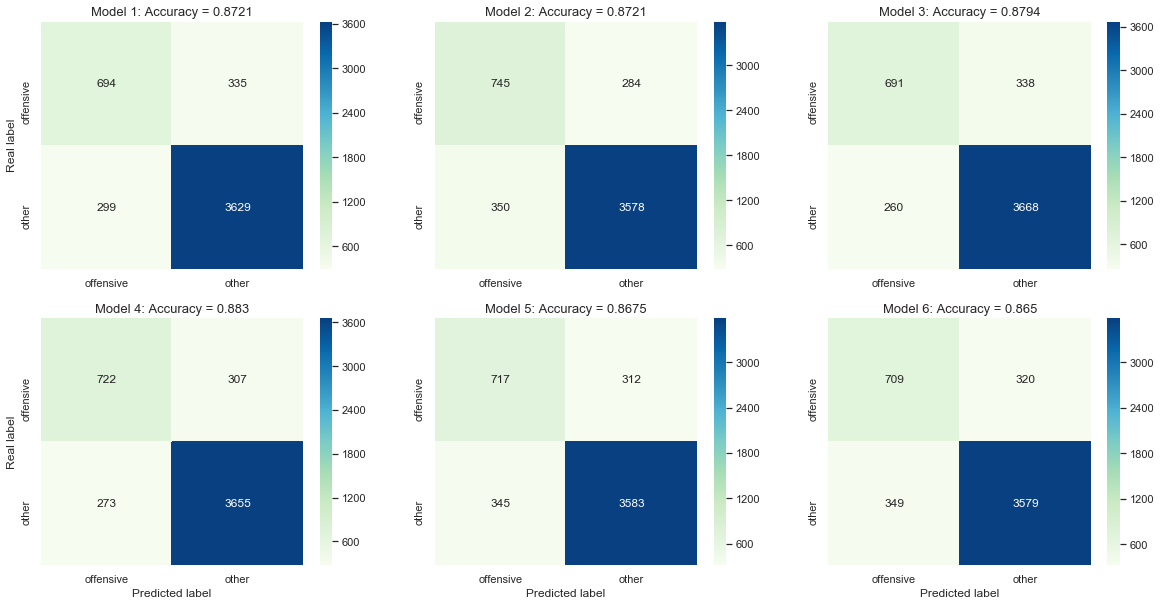

In [70]:
# Print the Confusion Matrices

y_test = test_y.detach().numpy()

# Create the confusion matrix
class_labels = ['offensive','other']
cm1=confusion_matrix(y_test,model_1_pred.detach().numpy())
cm2=confusion_matrix(y_test,model_2_pred.detach().numpy())
cm3=confusion_matrix(y_test,model_3_pred.detach().numpy())
cm4=confusion_matrix(y_test,model_4_pred.detach().numpy())
cm5=confusion_matrix(y_test,model_5_pred.detach().numpy())
cm6=confusion_matrix(y_test,model_6_pred.detach().numpy())

# Run the function to prepare the data to plot the confusion matrix
plt1 = plot_confusion_matrix(cm1, class_labels)
plt2 = plot_confusion_matrix(cm2, class_labels)
plt3 = plot_confusion_matrix(cm3, class_labels)
plt4 = plot_confusion_matrix(cm4, class_labels)
plt5 = plot_confusion_matrix(cm5, class_labels)
plt6 = plot_confusion_matrix(cm6, class_labels)

# Plot the confusion matrices
## Define figure size and axes
f = plt.figure(figsize = (20,10))
ax1 = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)
## Plot the matrices
sns.heatmap(plt1, annot=True, fmt='d', cmap='GnBu', ax=ax1).set_title('Model 1: Accuracy = '+ str(round(accuracy_score(y_test,model_1_pred.detach().numpy()),4)), size=13)
sns.heatmap(plt2, annot=True, fmt='d', cmap='GnBu', ax=ax2).set_title('Model 2: Accuracy = '+ str(round(accuracy_score(y_test,model_2_pred.detach().numpy()),4)), size=13)
sns.heatmap(plt3, annot=True, fmt='d', cmap='GnBu', ax=ax3).set_title('Model 3: Accuracy = '+ str(round(accuracy_score(y_test,model_3_pred.detach().numpy()),4)), size=13)
sns.heatmap(plt4, annot=True, fmt='d', cmap='GnBu', ax=ax4).set_title('Model 4: Accuracy = '+ str(round(accuracy_score(y_test,model_4_pred.detach().numpy()),4)), size=13)
sns.heatmap(plt5, annot=True, fmt='d', cmap='GnBu', ax=ax5).set_title('Model 5: Accuracy = '+ str(round(accuracy_score(y_test,model_5_pred.detach().numpy()),4)), size=13)
sns.heatmap(plt6, annot=True, fmt='d', cmap='GnBu', ax=ax6).set_title('Model 6: Accuracy = '+ str(round(accuracy_score(y_test,model_6_pred.detach().numpy()),4)), size=13)
# Set axis labels
ax4.set_xlabel("Predicted label")
ax5.set_xlabel("Predicted label")
ax6.set_xlabel("Predicted label")
ax1.set_ylabel("Real label")
ax4.set_ylabel("Real label")

print("Confusion Matrices")

#### Predicting Sample Tweets

In [10]:
def predict_sample_tweets(model, tweets):
    
    tweet_list = tweets
    
    lemma = lemmatize(tweets)
    cdl = create_doc_list(lemma)
    filtered_seq = filter_stopwords(cdl)
   
    stemmed_doclist = stemmer(filtered_seq)

    unique_words = uniqueWords(stemmed_doclist)

    uncommon_word_list = uncommon_word_list=uncommon_words(stemmed_doclist, word_threshold = 0)

    doclist_rm_uncommon, unique_words_rm_uncommon = filterWords_generateWordList(stemmed_doclist,
                                                                                   unique_words, 
                                                                                   uncommon_word_list)

    doclist_lg, unique_words_lg = filterWords_generateWordList(doclist_rm_uncommon,
                                                                 unique_words_rm_uncommon,
                                                                 words_to_remove)

    unique_words_lg = uniqueWords(doclist_lg)   
    seq_onehot_lg = onehot_encoder(doclist_lg, unique_words_lg)

    longest_tweet = 0

    for i in range(len(seq_onehot_lg)):
        tweet_length = np.shape(seq_onehot_lg[i])[0]
        if (tweet_length > longest_tweet):
            longest_tweet = tweet_length

    zero_vector = np.repeat(0, np.shape(seq_onehot_lg[0])[1], axis=None)
    
    for i in range(len(seq_onehot_lg)):
        tweet_length = np.shape(seq_onehot_lg[i])[0]
        while tweet_length < longest_tweet:
            seq_onehot_lg[i].append(zero_vector)
            tweet_length = np.shape(seq_onehot_lg[i])[0] 
            

    seq_idx_lg = encoder_index(seq_onehot_lg)

    zero_vector = 0

    for i in range(len(seq_idx_lg)):
        tweet_length = len(seq_idx_lg[i])
        while tweet_length < longest_tweet:
            seq_idx_lg[i].append(zero_vector)
            tweet_length = len(seq_idx_lg[i])

    save('seq_idx_lg_new.npy', seq_idx_lg)
    seq_idx_lg_new = np.load("seq_idx_lg_new.npy", allow_pickle = True)

    test_sequence = torch.from_numpy(np.asarray(seq_idx_lg_new))

    # predict sequence
    device = "cuda" if torch.cuda.is_available() else "cpu"

    test_sequence = test_sequence.to(device)
    
    if(len(test_sequence) == 0):
        "Your review must contain at least 1 word!"
        return None
    
    output, _ = model(test_sequence)
    output = output.to(device)
    
    results = []
    for i in output:
        if i <= 0.5:
            results.append('This is hate speech or neutral.') 
        else:
            results.append('This is offensive language.')
    
    return tweets, results

In [13]:
# Sample tweets from Donald Trump

sample_tweets = ["To the people of South Carolina, Tom Steyer is a joke, laughed at by everyone, a total incompetent. He made money in coal, now he “hates” coal. Did you see him fawning over Crazy Bernie? Has no chance, a loser for South Carolina, doesn’t deserve your vote!",
                "How can a dummy dope like Harry Hurt, who wrote a failed book about me but doesn’t know me or anything about me, be on TV discussing Trump?",
                "@MeghanMcCain was terrible on @TheFive yesterday. Angry and obnoxious, she will never make it on T.V. @FoxNews can do so much better!"]

predict_sample_tweets(model_6, sample_tweets)

(['To the people of South Carolina, Tom Steyer is a joke, laughed at by everyone, a total incompetent. He made money in coal, now he “hates” coal. Did you see him fawning over Crazy Bernie? Has no chance, a loser for South Carolina, doesn’t deserve your vote!',
  'How can a dummy dope like Harry Hurt, who wrote a failed book about me but doesn’t know me or anything about me, be on TV discussing Trump?',
  '@MeghanMcCain was terrible on @TheFive yesterday. Angry and obnoxious, she will never make it on T.V. @FoxNews can do so much better!'],
 ['This is offensive language.',
  'This is offensive language.',
  'This is offensive language.'])